In [1]:
from lib.models import CNNLSTM
import torch
from torch import nn
from tqdm import tqdm
from lib.utils import cms
import matplotlib.pyplot as plt

from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader


/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = CNNLSTM().cuda()
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
device = 'cuda'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-2)
data_dir = 'w3_small_balanced_normalized'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=64,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)

Params:  39110


In [21]:
# lre = torch.linspace(-6,1,len(trainloader))
# lrs = 10**lre
# lri = []
# lossi = []
# model.train()
# loss_tr_total = 0
# for i,(X_tr,y_tr) in tqdm(enumerate(trainloader)):
#     optimizer = torch.optim.Adam(model.parameters(),lr=lrs[i])
#     X_tr,y_tr = X_tr.to(device),y_tr.to(device)
#     logits = model(X_tr)
#     loss = criterion(logits,y_tr)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     loss_tr_total += loss.item()
#     lri.append(lre[i])
#     lossi.append(loss.item())
# plt.plot(lri,lossi)


In [4]:
loss_tr = []
loss_dev = []

In [5]:
optimizer = torch.optim.Adam(model.parameters(),lr=3e-5)

pbar = tqdm(range(5))

for epoch in pbar:
    # train loop
    model.train()
    loss_tr_total = 0
    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(device),y_tr.to(device)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))
    # dev loop
    model.eval()
    loss_dev_total = 0
    for (X_dv,y_dv) in tqdm(devloader):
        X_dv,y_dv = X_dv.to(device),y_dv.to(device)
        logits = model(X_dv)
        loss = criterion(logits,y_dv)
        loss_dev_total += loss.item()
    loss_dev.append(loss_dev_total/len(devloader))

    print(f'\033[94mTrain Loss: {loss_tr[-1]:.4f}\033[93m Val Loss: {loss_dev[-1]:.4f}\033[0m')


 20%|██        | 1/5 [00:43<02:55, 43.96s/it]

Train Loss: 0.5414 Val Loss: 0.4700


 40%|████      | 2/5 [01:27<02:10, 43.63s/it]

Train Loss: 0.3730 Val Loss: 0.7148


 60%|██████    | 3/5 [02:10<01:27, 43.61s/it]

Train Loss: 0.3365 Val Loss: 0.3477


 80%|████████  | 4/5 [02:53<00:43, 43.37s/it]

Train Loss: 0.3242 Val Loss: 0.3492


100%|██████████| 5/5 [03:37<00:00, 43.48s/it]

Train Loss: 0.3150 Val Loss: 0.3430


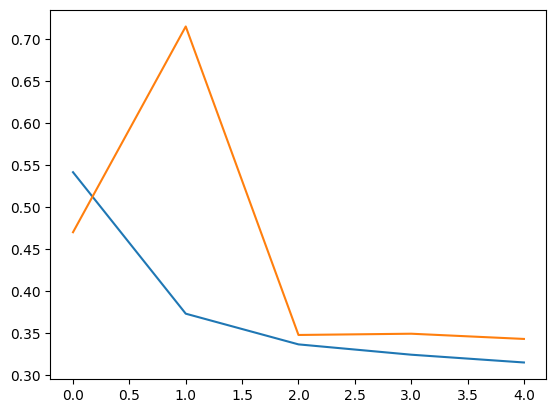

In [6]:
plt.plot(loss_tr)
plt.plot(loss_dev)

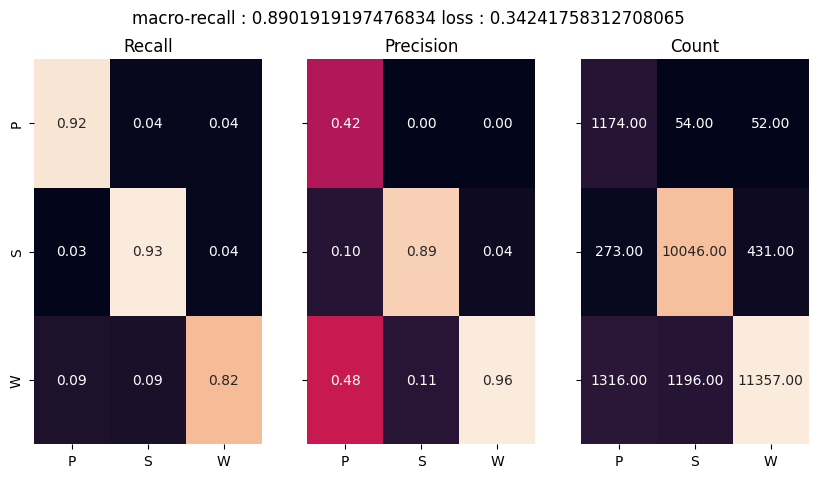

In [7]:
y_true = torch.Tensor()
y_pred = torch.Tensor().cuda()
model.eval()
loss_dev_total = 0
for (X_dv,y_dv) in devloader:
    X_dv,y_dv = X_dv.to(device),y_dv.to(device)
    logits = model(X_dv)
    loss = criterion(logits,y_dv)
    loss_dev_total += loss.item()

    y_true = torch.cat([y_true,y_dv.cpu().argmax(axis=1)])
    y_pred = torch.cat([y_pred,torch.softmax(logits,dim=1).argmax(axis=1)])

cms(y_true=y_true,y_pred=y_pred.cpu(),loss=loss_dev_total/len(devloader))

In [23]:
torch.save(model,"model.pt")